In [14]:
# Import necessary libraries for analysis and geospatial processing

import pandas as pd                    # For handling tabular data (optional)
import numpy as np                    # For numerical operations
import matplotlib.pyplot as plt       # For plotting and visualization
import rasterio                       # For reading/writing raster data
import os                             # For working with directories and file paths
from rasterio.mask import mask        # For masking rasters using vector geometries
import geopandas as gpd               # For working with vector GIS data (e.g., shapefiles, GeoPackages)


In [15]:
# Set working directory to the folder containing your PlanetScope image
# Update this path if you're working with a different season or dataset

os.chdir(r"C:\Users\vnhuy\Documents\UCSC\TCNP\Data\2022\dry season\02-26-2022_8b_psscene_analytic_8b_sr_udm2\PSScene")

# Specify the name of the 8-band surface reflectance image file
image_file = '20220226_023232_05_2449_3B_AnalyticMS_SR_8b_clip.tif'


Reflectance Coefficients for 8 Bands: {1: 2.2541351527447213e-05, 2: 2.1769558132205906e-05, 3: 2.326663009254955e-05, 4: 2.3610776617027702e-05, 5: 2.5376041409975372e-05, 6: 2.8418829392122267e-05, 7: 3.0381486190198455e-05, 8: 4.4979861343886404e-05}
Final NDVI Min: -0.10418562194957122
Final NDVI Max: 0.9470964385499308
Final NDVI Mean: 0.5557217150424931


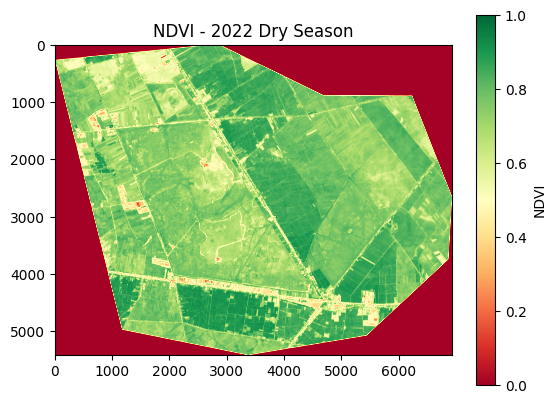

In [16]:
from xml.dom import minidom

# Parse the XML metadata file to extract reflectance coefficients
xmldoc = minidom.parse("20220226_023232_05_2449_3B_AnalyticMS_8b_metadata_clip.xml")
nodes = xmldoc.getElementsByTagName("ps:bandSpecificMetadata")

# Extract reflectance coefficients for all 8 bands
coeffs = {}
for node in nodes:
    bn = node.getElementsByTagName("ps:bandNumber")[0].firstChild.data
    if bn in ['1', '2', '3', '4', '5', '6', '7', '8']:
        i = int(bn)
        value = node.getElementsByTagName("ps:reflectanceCoefficient")[0].firstChild.data
        coeffs[i] = float(value)

print("Reflectance Coefficients for 8 Bands:", coeffs)

# Open the image and read bands
# Band 6 = Red; Band 8 = Near-Infrared (NIR)
with rasterio.open(image_file) as src:
    band_red = src.read(6).astype(float)
    band_nir = src.read(8).astype(float)

# Mask out pixels where either band is 0 (invalid data)
mask = (band_red == 0) | (band_nir == 0)
band_red[mask] = np.nan
band_nir[mask] = np.nan

# Apply reflectance coefficients
band_red *= coeffs[6]   # Red band
band_nir *= coeffs[8]   # NIR band

# 🌿 Calculate NDVI (Normalized Difference Vegetation Index)
epsilon = 1e-10  # Prevent divide-by-zero errors
ndvi = (band_nir - band_red) / (band_nir + band_red + epsilon)

# Replace any remaining NaNs with 0
ndvi = np.nan_to_num(ndvi, nan=0.0)

# Print NDVI summary statistics
print("Final NDVI Min:", np.min(ndvi))
print("Final NDVI Max:", np.max(ndvi))
print("Final NDVI Mean:", np.mean(ndvi))

# Plot NDVI
plt.imshow(ndvi, cmap='RdYlGn', vmin=0, vmax=1)
plt.colorbar(label='NDVI')
plt.title('NDVI - 2022 Dry Season')
plt.show()


In [17]:
def calculate_agb(ndvi):
    return 19.15 + (123.42 * ndvi) + (56.42 * (ndvi ** 2))
# Apply the AGB function to the NDVI data
# This produces a biomass map (in tons per hectare)

agb = calculate_agb(ndvi)


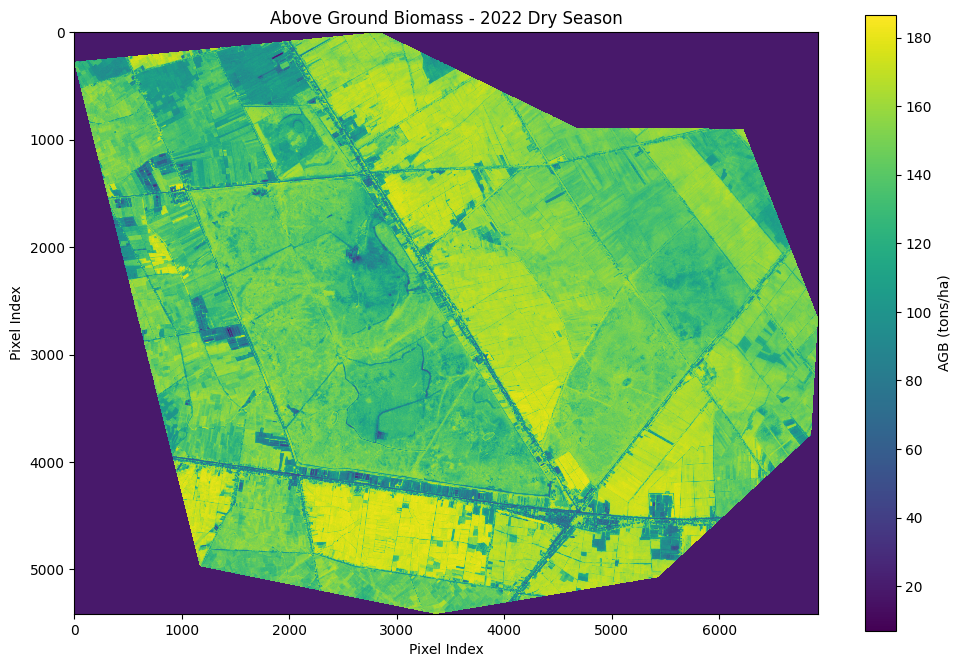

AGB Min: 6.903829543365808
AGB Max: 186.64891212385822
AGB Mean: 111.54557721736202


In [18]:
# Plot the Aboveground Biomass (AGB) as a heatmap

plt.figure(figsize=(12, 8))
plt.imshow(agb, cmap='viridis', interpolation='nearest')  # Use 'viridis' colormap for clarity
plt.colorbar(label='AGB (tons/ha)')
plt.title('Above Ground Biomass - 2022 Dry Season')
plt.xlabel('Pixel Index')
plt.ylabel('Pixel Index')
plt.show()

# Display basic statistics of AGB
print("AGB Min:", np.min(agb))
print("AGB Max:", np.max(agb))
print("AGB Mean:", np.mean(agb))


Carbon Stock Min: 3.313838180815588
Carbon Stock Max: 89.59147781945194
Carbon Stock Mean: 53.541877064333775


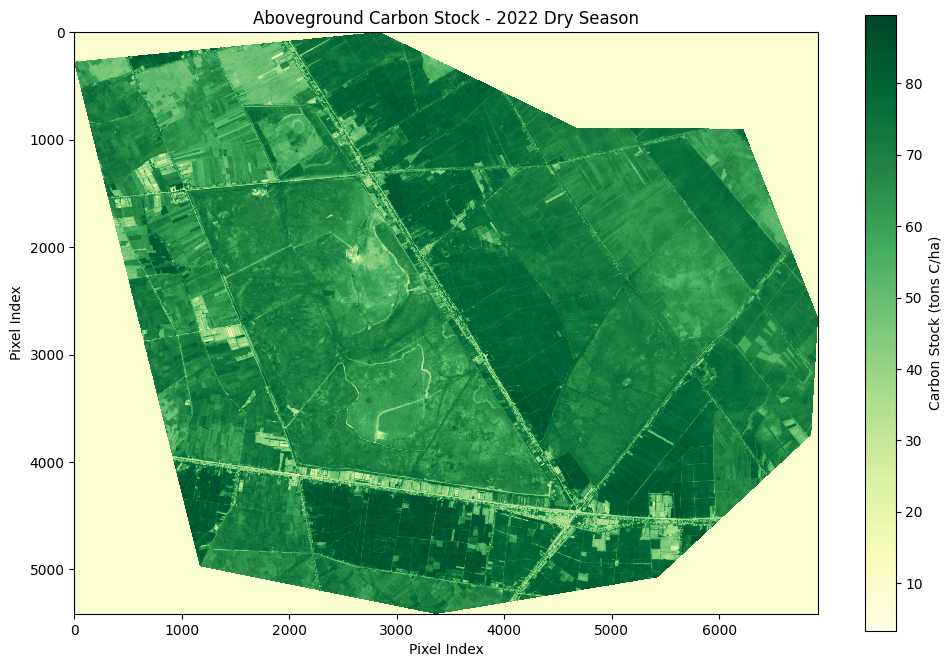

In [19]:
# Calculate aboveground carbon stock using a standard conversion factor
# The IPCC default is that ~48% of AGB is carbon

carbon_stock = agb * 0.48

# Display basic statistics of carbon stock
print("Carbon Stock Min:", np.min(carbon_stock))
print("Carbon Stock Max:", np.max(carbon_stock))
print("Carbon Stock Mean:", np.mean(carbon_stock))

# Plot carbon stock as a heatmap

plt.figure(figsize=(12, 8))
plt.imshow(carbon_stock, cmap='YlGn', interpolation='nearest')  # Yellow-Green colormap
plt.colorbar(label='Carbon Stock (tons C/ha)')
plt.title('Aboveground Carbon Stock - 2022 Dry Season')
plt.xlabel('Pixel Index')
plt.ylabel('Pixel Index')
plt.show()


In [20]:
# Save NDVI results as a GeoTIFF file that can be opened in GIS software (QGIS, ArcGIS, etc.)

from rasterio.transform import from_origin

# Print the current directory to confirm where the output will be saved
print("File will be saved in:", os.getcwd())

# Set the output filename (you can change this as needed)
output_path = "ndvi_2022_dryseason.tif"

# Copy metadata from the input image and update it for NDVI output
with rasterio.open(image_file) as src:
    kwargs = src.meta.copy()  # Copy original metadata
    kwargs.update({
        "dtype": rasterio.float32,  # NDVI is stored as 32-bit float
        "count": 1                  # Only one band for NDVI
    })

    # Write the NDVI array to the new GeoTIFF file
    with rasterio.open(output_path, 'w', **kwargs) as dst:
        dst.write_band(1, ndvi.astype(rasterio.float32))  # Write NDVI to the first (and only) band

print(f"NDVI raster saved to: {output_path}")


File will be saved in: C:\Users\vnhuy\Documents\UCSC\TCNP\Data\2022\dry season\02-26-2022_8b_psscene_analytic_8b_sr_udm2\PSScene
NDVI raster saved to: ndvi_2022_dryseason.tif


In [21]:
# Save the calculated carbon stock as a GeoTIFF raster file


# Set the output filename (update as needed)
output_path = "carbon_stock_2022_dryseason.tif"

# Open the original image file to copy its spatial metadata (CRS, resolution, etc.)
with rasterio.open(image_file) as src:
    kwargs = src.meta.copy()  # Copy metadata from original image
    kwargs.update({
        "dtype": rasterio.float32,  # Use float32 format for carbon values
        "count": 1                  # Only one band for carbon stock
    })

    # Write the carbon stock array to a new GeoTIFF file
    with rasterio.open(output_path, 'w', **kwargs) as dst:
        dst.write_band(1, carbon_stock.astype(rasterio.float32))  # Write data to band 1

print(f"Carbon stock raster saved to: {output_path}")



Carbon stock raster saved to: carbon_stock_2022_dryseason.tif


In [22]:
# Save the calculated Aboveground Biomass (AGB) as a GeoTIFF file

# Define the output path where the AGB raster will be saved
biomass_path = r"C:\Users\vnhuy\Documents\UCSC\TCNP\Data\2022\dry season\02-26-2022_8b_psscene_analytic_8b_sr_udm2\PSScene\biomass_2022_dryseason.tif"

# Use the carbon stock GeoTIFF to copy spatial metadata (same extent, CRS, resolution)
with rasterio.open(r"C:\Users\vnhuy\Documents\UCSC\TCNP\Data\2022\dry season\02-26-2022_8b_psscene_analytic_8b_sr_udm2\PSScene\carbon_stock_2022_dryseason.tif") as src:
    kwargs = src.meta.copy()
    kwargs.update({
        "dtype": rasterio.float32,  # Float32 is used for continuous biomass values
        "count": 1                  # Only one band for AGB
    })

    # Write the AGB values to the new raster file
    with rasterio.open(biomass_path, 'w', **kwargs) as dst:
        dst.write(agb.astype(rasterio.float32), 1)

print(f"Biomass raster saved to: {biomass_path}")



Biomass raster saved to: C:\Users\vnhuy\Documents\UCSC\TCNP\Data\2022\dry season\02-26-2022_8b_psscene_analytic_8b_sr_udm2\PSScene\biomass_2022_dryseason.tif


In [ ]:
import rasterio
from rasterio.mask import mask
import geopandas as gpd
#"C:\Users\vnhuy\Documents\UCSC\TCNP\Data\2024\wet season\11-09-24_8bands_psscene_analytic_8b_sr_udm2\PSScene\ndvi_2024_wetseason.tif"

# File paths
ndvi_path = r"C:\Users\vnhuy\Documents\UCSC\TCNP\Data\2022\dry season\02-26-2022_8b_psscene_analytic_8b_sr_udm2\PSScene\ndvi_2022_dryseason.tif"
aoi_path = r"C:\Users\vnhuy\Documents\UCSC\TCNP\TCNP GIS\working layers\dissolved_aoi.gpkg"
ndvi_cropped_path = r"C:\Users\vnhuy\Documents\UCSC\TCNP\Data\2022\dry season\ndvi_2022_dryseason_cropped.tif"

# Load the AOI polygon
aoi = gpd.read_file(aoi_path)  # Load GeoPackage
aoi_geojson = [feature["geometry"] for feature in aoi.__geo_interface__["features"]]  # Convert to GeoJSON format

# Function to crop raster
def crop_raster(input_path, output_path):
    with rasterio.open(input_path) as src:
        out_image, out_transform = mask(src, aoi_geojson, crop=True)  # Crop raster
        out_meta = src.meta.copy()  # Copy metadata
        out_meta.update({
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform,
            "count": 1  # Single band for NDVI
        })

    # Save the cropped raster
    with rasterio.open(output_path, "w", **out_meta) as dest:
        dest.write(out_image[0], 1)  # Write the first band
    print(f"Cropped NDVI raster saved to: {output_path}")

# Crop NDVI
crop_raster(ndvi_path, ndvi_cropped_path)


Cropped NDVI raster saved to: C:\Users\vnhuy\Documents\UCSC\TCNP\Data\2022\dry season\ndvi_2022_dryseason_cropped.tif


In [24]:
# Crop the Aboveground Biomass (AGB) raster to your Area of Interest (AOI)

# Define file paths
biomass_path = r"C:\Users\vnhuy\Documents\UCSC\TCNP\Data\2022\dry season\02-26-2022_8b_psscene_analytic_8b_sr_udm2\PSScene\biomass_2022_dryseason.tif"
aoi_path = r"C:\Users\vnhuy\Documents\UCSC\TCNP\TCNP GIS\working layers\dissolved_aoi.gpkg"
biomass_cropped_path = r"C:\Users\vnhuy\Documents\UCSC\TCNP\Data\2022\dry season\biomass_2022_dryseason_cropped.tif"

# Load the AOI polygon from GeoPackage
aoi = gpd.read_file(aoi_path)

# Convert AOI to GeoJSON format for raster masking
aoi_geojson = [feature["geometry"] for feature in aoi.__geo_interface__["features"]]

# Define a reusable function to crop raster data
def crop_raster(input_path, output_path):
    with rasterio.open(input_path) as src:
        out_image, out_transform = mask(src, aoi_geojson, crop=True)
        out_meta = src.meta.copy()
        out_meta.update({
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform,
            "count": 1  # Single-band raster (AGB)
        })

        # 💾 Save the cropped output
        with rasterio.open(output_path, "w", **out_meta) as dest:
            dest.write(out_image[0], 1)

    print(f"Cropped biomass raster saved to: {output_path}")

# Run the crop function for AGB
crop_raster(biomass_path, biomass_cropped_path)


Cropped biomass raster saved to: C:\Users\vnhuy\Documents\UCSC\TCNP\Data\2022\dry season\biomass_2022_dryseason_cropped.tif


In [25]:
# Crop the Carbon Stock raster to your Area of Interest (AOI)

# Define file paths
carbon_stock_path = r"C:\Users\vnhuy\Documents\UCSC\TCNP\Data\2022\dry season\02-26-2022_8b_psscene_analytic_8b_sr_udm2\PSScene\carbon_stock_2022_dryseason.tif"
aoi_path = r"C:\Users\vnhuy\Documents\UCSC\TCNP\TCNP GIS\working layers\dissolved_aoi.gpkg"
output_cropped_path = r"C:\Users\vnhuy\Documents\UCSC\TCNP\Data\2022\dry season\2022_dryseason_carbon_stock_cropped.tif"

# Load the AOI boundary from the GeoPackage
aoi = gpd.read_file(aoi_path)

# Convert AOI geometry to GeoJSON format
aoi_geojson = [feature["geometry"] for feature in aoi.__geo_interface__["features"]]

# Open the carbon stock raster and apply the AOI mask
with rasterio.open(carbon_stock_path) as src:
    out_image, out_transform = mask(src, aoi_geojson, crop=True)
    out_meta = src.meta.copy()

    # Update metadata for the cropped output
    out_meta.update({
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform,
        "count": 1  # Single band
    })

# Save the cropped raster to disk
with rasterio.open(output_cropped_path, "w", **out_meta) as dest:
    dest.write(out_image[0], 1)

print(f"Cropped carbon stock raster saved at: {output_cropped_path}")


Cropped carbon stock raster saved at: C:\Users\vnhuy\Documents\UCSC\TCNP\Data\2022\dry season\2022_dryseason_carbon_stock_cropped.tif


In [26]:
# Calculate basic statistics (min, max, mean) for the cropped carbon stock raster
# Define the file path to your cropped raster
cropped_raster_path = r"C:\Users\vnhuy\Documents\UCSC\TCNP\Data\2022\dry season\2022_dryseason_carbon_stock_cropped.tif"

# Open the raster and read the data
with rasterio.open(cropped_raster_path) as src:
    data = src.read(1)  # Read the first (and only) band
    data = data[data != src.nodata]  # Remove no-data values

    # Calculate raster statistics
    min_value = np.min(data)
    max_value = np.max(data)
    mean_value = np.mean(data)

# Print out the results
print(f"Minimum Carbon Stock: {min_value}")
print(f"Maximum Carbon Stock: {max_value}")
print(f"Mean Carbon Stock: {mean_value}")


Minimum Carbon Stock: 13.663022994995117
Maximum Carbon Stock: 83.56163787841797
Mean Carbon Stock: 66.00420379638672


Minimum NDVI Value: 0.0730
Maximum NDVI Value: 0.8918
Mean NDVI Value: 0.7199


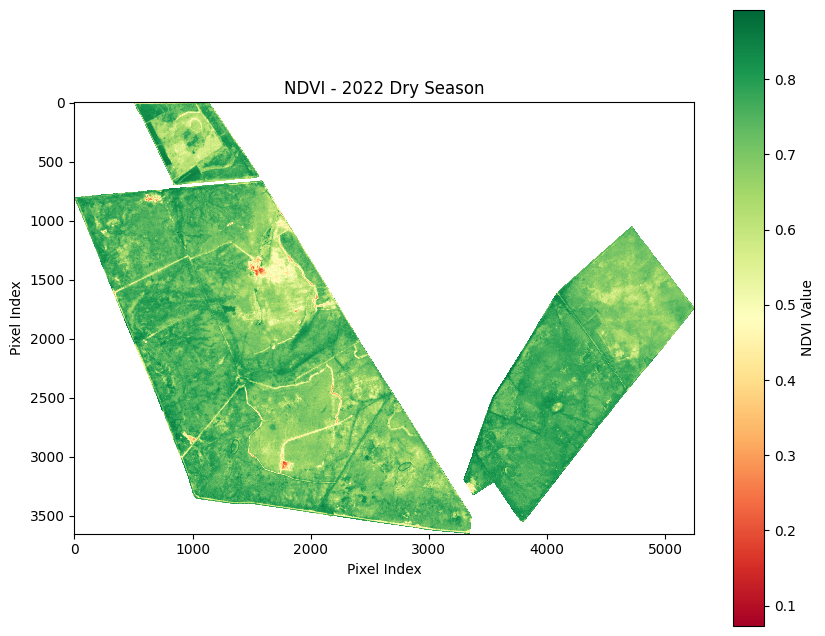

In [27]:
# Calculate statistics and visualize the cropped NDVI raster

# File path to the cropped NDVI raster
ndvi_path = r"C:\Users\vnhuy\Documents\UCSC\TCNP\Data\2022\dry season\ndvi_2022_dryseason_cropped.tif"

# Open the raster and read the NDVI values
with rasterio.open(ndvi_path) as src:
    data = src.read(1)  # Read the first band (NDVI values)

    # Mask out no-data values
    data = np.ma.masked_equal(data, src.nodata)

    # Calculate summary statistics
    min_value = data.min()
    max_value = data.max()
    mean_value = data.mean()

    # Print NDVI statistics with 4 decimal places
    print(f"Minimum NDVI Value: {min_value:.4f}")
    print(f"Maximum NDVI Value: {max_value:.4f}")
    print(f"Mean NDVI Value: {mean_value:.4f}")

# Plot NDVI using a color scale
plt.figure(figsize=(10, 8))
plt.imshow(data, cmap='RdYlGn', interpolation='nearest')  # Red-Yellow-Green for vegetation
plt.colorbar(label='NDVI Value')
plt.title('NDVI - 2022 Dry Season')
plt.xlabel('Pixel Index')
plt.ylabel('Pixel Index')
plt.show()


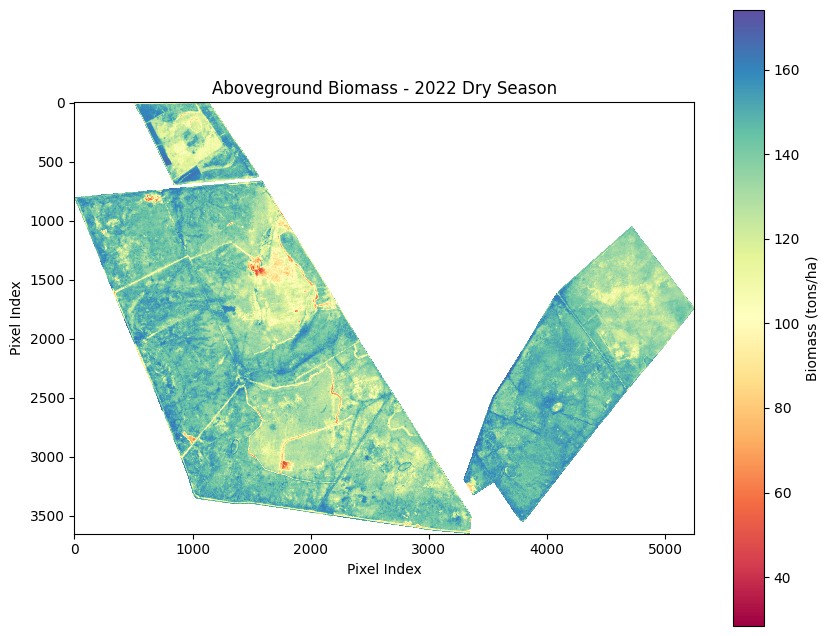

In [28]:
# Visualize the cropped Aboveground Biomass (AGB) raster

import rasterio
import numpy as np
import matplotlib.pyplot as plt

# File path to the cropped AGB raster
raster_path = r"C:\Users\vnhuy\Documents\UCSC\TCNP\Data\2022\dry season\biomass_2022_dryseason_cropped.tif"

# Open the raster and read the biomass values
with rasterio.open(raster_path) as src:
    data = src.read(1)  # Read the first band (AGB values)

    # Mask out no-data values
    data = np.ma.masked_equal(data, src.nodata)

# Plot the biomass raster using a custom colormap
plt.figure(figsize=(10, 8))
plt.imshow(data, cmap='Spectral', interpolation='nearest')  # 'Spectral' colormap shows value gradients well
plt.colorbar(label='Biomass (tons/ha)')
plt.title('Aboveground Biomass - 2022 Dry Season')
plt.xlabel('Pixel Index')
plt.ylabel('Pixel Index')
plt.show()


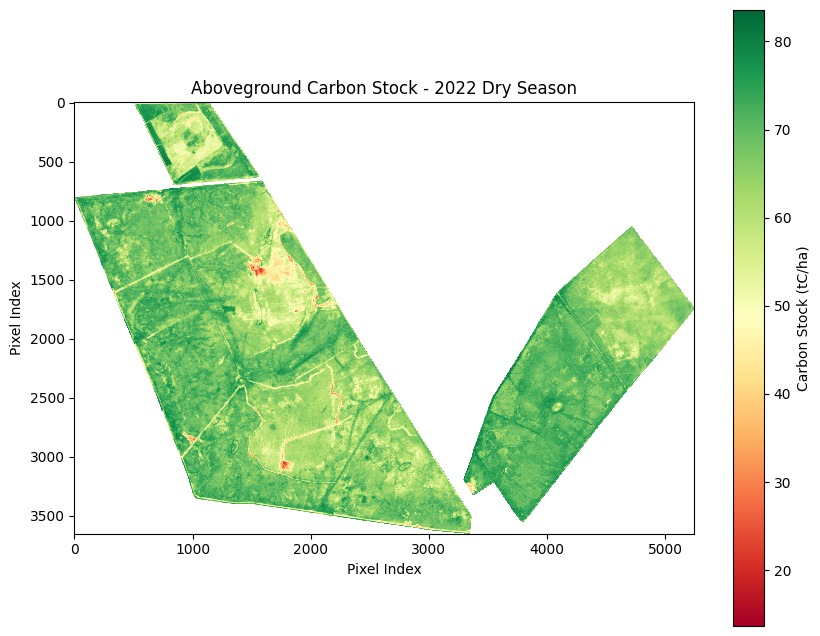

In [29]:
# Visualize the cropped Aboveground Carbon Stock raster

# File path to the cropped carbon stock raster
carbon_stock_path = r"C:\Users\vnhuy\Documents\UCSC\TCNP\Data\2022\dry season\2022_dryseason_carbon_stock_cropped.tif"

# Open the raster and read the carbon stock values
with rasterio.open(carbon_stock_path) as src:
    data = src.read(1)  # Read the first (and only) band
    data = np.ma.masked_equal(data, src.nodata)  # Mask out no-data values

# Plot the raster with a continuous color scale
plt.figure(figsize=(10, 8))
plt.imshow(data, cmap='RdYlGn', interpolation='nearest')  # Red-Yellow-Green for vegetation/carbon
plt.colorbar(label='Carbon Stock (tC/ha)')
plt.title('Aboveground Carbon Stock - 2022 Dry Season')
plt.xlabel('Pixel Index')
plt.ylabel('Pixel Index')
plt.show()

# Optionally define colormap limits for consistency across plots
vmin = 0
vmax = data.max()


In [32]:
import rasterio
import numpy as np

# File paths (update if needed)
ndvi_path = r"C:\Users\vnhuy\Documents\UCSC\TCNP\Data\2022\dry season\ndvi_2022_dryseason_cropped.tif"
biomass_path = r"C:\Users\vnhuy\Documents\UCSC\TCNP\Data\2022\dry season\biomass_2022_dryseason_cropped.tif"
carbon_path = r"C:\Users\vnhuy\Documents\UCSC\TCNP\Data\2022\dry season\2022_dryseason_carbon_stock_cropped.tif"

# Define a helper function to calculate stats
def summarize_raster(path, label):
    with rasterio.open(path) as src:
        data = src.read(1)
        data = data[data != src.nodata]  # Mask no-data values
        print(f"\n {label} Statistics:")
        print(f"Minimum: {np.min(data):.4f}")
        print(f"Maximum: {np.max(data):.4f}")
        print(f"Mean:    {np.mean(data):.4f}")

# Run summaries
summarize_raster(ndvi_path, "NDVI")
summarize_raster(biomass_path, "Biomass (tons/ha)")
summarize_raster(carbon_path, "Carbon Stock (tC/ha)")



 NDVI Statistics:
Minimum: 0.0730
Maximum: 0.8918
Mean:    0.7199

 Biomass (tons/ha) Statistics:
Minimum: 28.4646
Maximum: 174.0867
Mean:    137.5088

 Carbon Stock (tC/ha) Statistics:
Minimum: 13.6630
Maximum: 83.5616
Mean:    66.0042
